# Data download and processing from Swissprot

Downloaded the data on 13th of May 2024. 571,282 results filtering for reviewed "Swiss-Prot". (https://www.uniprot.org/uniprotkb?query=*&facets=reviewed%3Atrue)

Selected download TSV and the columns, Seqeunce (under Sequences tab), EC number (under Function).

Unzipped the downloaded file.

## 1. Protein to EC processing


In [11]:
import pandas as pd

swissprot = pd.read_csv('raw_data/uniprotkb_AND_reviewed_true_2024_05_13.tsv', sep='\t')
swissprot

,Entry,Entry Name,Length,Sequence,EC number
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
3,A0A024SC78,CUTI1_HYPJR,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74
4,A0A024SH76,GUX2_HYPJR,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91
...,...,...,...,...,...
571277,V9HVX0,YPAA_ECOLI,61,MTIAERLRQEGHQIGWQEGKLEGLHEQAIKIALRMLEQGFDRDQVL...,NaN
571278,W5X2N3,AP_FRAAN,193,MGWVWKDDDEQGGHVNPSAADISPRLDGDRCSTRKVVRTQCKTEEV...,NaN
571279,W6JGV7,REP_CPBDV,484,MSAPLSIEQDDLLTDDLKSWLSDIDFSNDNEEAIEMEPSDIEMSSP...,NaN
571280,W6JHZ8,VP1_CPBDV,210,MNVKGASDKAQLAMQAEWEEVLAPEGALAVEEASSVLKISDDERRS...,NaN


Drop sequences that are fragments

In [12]:
fragments = pd.read_csv('raw_data/fragments.tsv', sep='\t')['Entry'].values
swissprot = swissprot[~swissprot['Entry'].isin(fragments)]
swissprot


,Entry,Entry Name,Length,Sequence,EC number
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
3,A0A024SC78,CUTI1_HYPJR,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74
4,A0A024SH76,GUX2_HYPJR,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91
...,...,...,...,...,...
571277,V9HVX0,YPAA_ECOLI,61,MTIAERLRQEGHQIGWQEGKLEGLHEQAIKIALRMLEQGFDRDQVL...,NaN
571278,W5X2N3,AP_FRAAN,193,MGWVWKDDDEQGGHVNPSAADISPRLDGDRCSTRKVVRTQCKTEEV...,NaN
571279,W6JGV7,REP_CPBDV,484,MSAPLSIEQDDLLTDDLKSWLSDIDFSNDNEEAIEMEPSDIEMSSP...,NaN
571280,W6JHZ8,VP1_CPBDV,210,MNVKGASDKAQLAMQAEWEEVLAPEGALAVEEASSVLKISDDERRS...,NaN


## Explode out EC number so each EC has it's own row

In [15]:
swissprot = swissprot[swissprot['EC number'].notna()]
# Drop rows that don't have an ec number
swissprot['EC All'] = swissprot['EC number'].values
# Now expand out the ones we have left
swissprot['EC number'] = [ec.split(';') for ec in swissprot['EC number']]
# Then check how many have mulitple
print(sum([1 if len(ec) > 1 else 0 for ec in swissprot['EC number'].values]))
swissprot = swissprot.explode('EC number')
# Clean the EC numbers
swissprot['EC number'] = [ec.replace(' ', '') for ec in swissprot['EC number']]
swissprot
print(swissprot['EC number'].nunique())
print(swissprot['Sequence'].nunique())

0
5756
230886


## Filtering steps 

* Filter to a certain sequence length
* Drop duplicates
* Remove EC numbers with dash

In [16]:
swissprot = swissprot[swissprot['Length'] > 100]
swissprot = swissprot[swissprot['Length'] < 1024] #used to be 1024
swissprot = swissprot[~swissprot['EC number'].str.contains('-')]
print('Partially filled EC numbers: ', len(swissprot))
swissprot = swissprot.drop_duplicates(subset=['Sequence', 'EC number'])
print(swissprot['EC number'].nunique())
print(swissprot['Sequence'].nunique())
swissprot

Partially filled EC numbers:  237556
5399
188331


,Entry,Entry Name,Length,Sequence,EC number,EC All
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,3.2.1.39
3,A0A024SC78,CUTI1_HYPJR,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,3.1.1.74
4,A0A024SH76,GUX2_HYPJR,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,3.2.1.91
6,A0A044RE18,BLI_ONCVO,693,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,3.4.21.75,3.4.21.75
...,...,...,...,...,...,...
555831,Q05115,AMDA_BORBO,240,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,4.1.1.76
564731,Q6HX62,Y3032_BACAN,584,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,3.5.4.2
564754,Q6L032,Y1085_PICTO,573,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,3.5.4.2
568711,Q94MV8,VG56_BPLZ5,172,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,3.6.1.12


## 2. Reaction to EC processing

EC and reaction data were downloaded from multiple sources, the first being ECReact.

1. ECReact: https://www.nature.com/articles/s41467-022-28536-w, with the data downloaded from https://github.com/rxn4chemistry/biocatalysis-model specifically, https://github.com/rxn4chemistry/biocatalysis-model/blob/main/data/ecreact-1.0.csv
2. EnzymeMap: https://chemrxiv.org/engage/chemrxiv/article-details/643e9f4034f4ff2ea4f4f84e https://zenodo.org/records/8254726 and the data https://github.com/hesther/enzymemap, using the data file https://github.com/hesther/enzymemap/blob/main/data/processed_reactions.csv.gz

In [17]:
ECreact = pd.read_csv('raw_data/ECReact.csv')
ECreact['rxn_smiles'] = ECreact['rxn_smiles'].str.split('|').str[0] + '>>' + ECreact['rxn_smiles'].str.split('>>').str[1]
ECreact.rename(columns={'rxn_smiles': 'Reaction', 'ec': 'EC number', 'source':'Source'}, inplace=True)
ECreact

,Reaction,EC number,Source
0,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.2.1.8,brenda_reaction_smiles
1,C=C(C)CCOP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCO...,2.5.1.85,brenda_reaction_smiles
2,N.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O...,1.4.1.4,brenda_reaction_smiles
3,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.1.1.3,brenda_reaction_smiles
4,Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2.7.7.9,brenda_reaction_smiles
...,...,...,...
62217,CCCCC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCC(=O)O[C@@...,2.3.1.76,pathbank_reaction_smiles
62218,CCCCCCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O...,2.7.8.41,pathbank_reaction_smiles
62219,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCC...,2.7.8.41,pathbank_reaction_smiles
62220,CCCCCC/C=C\CCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCC...,2.7.8.41,pathbank_reaction_smiles


In [18]:
enzymemap = pd.read_csv('raw_data/EnzymeMap.csv')
print(len(enzymemap))
enzymemap.rename(columns={'ec_num': 'EC number', 'unmapped': 'Reaction', 'mapped': 'Mapped Reaction', 'orig_rxn_text':'Reaction Text'}, inplace=True)
enzymemap = enzymemap[['Reaction', 'Mapped Reaction', 'EC number', 'Reaction Text']]
enzymemap.drop_duplicates(subset=['Reaction', 'EC number'], inplace=True)
print(enzymemap['EC number'].nunique())
print(enzymemap['Reaction'].nunique())
print(enzymemap['Mapped Reaction'].nunique())
enzymemap

349458
4552
47640
47800


,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


In [19]:
enzymemap.dropna(subset=['Mapped Reaction']) #just double check that all of them have mapped reactions

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


### Append EC numbers that are covered by ECreact but not by EnzymeMap, to EnzymeMap

In [20]:
#find the EC numbers covered by ECreact but not by enzymemap
ECreact = ECreact[~ECreact['EC number'].str.contains('-')]
not_covered = ECreact[~ECreact['EC number'].isin(enzymemap['EC number'].unique())]
not_covered['EC number'].nunique()

2353

In [21]:
reaction2EC = pd.concat((enzymemap, not_covered[['Reaction', 'EC number']])).sort_values(by='EC number')
print(reaction2EC['EC number'].nunique())
print(reaction2EC['Reaction'].nunique())
reaction2EC

6905
56144


,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
15228,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,7.6.2.j,NaN
21396,C[C@@]1(O)OC[C@H](O)C1(O)O.Nc1ncnc2c1ncn2[C@@H...,NaN,7.6.2.l,NaN
34012,*CS(=O)(=O)[O-].Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO...,NaN,7.6.2.o,NaN
15541,Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1.Nc1ncnc2c1ncn2...,NaN,7.6.2.p,NaN


## 3. Filter protein2EC and reaction2EC to intersection of their EC numbers

In [22]:
ns_swissprot = swissprot[~swissprot['EC number'].isin(reaction2EC['EC number'].unique())]
ns_swissprot

,Entry,Entry Name,Length,Sequence,EC number,EC All
11,A0A061I403,FICD_CRIGR,455,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,2.7.7.108,2.7.7.108
15,A0A067XR63,XTH7_DIOKA,268,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,2.4.1.207,2.4.1.207
16,A0A067XRK9,XTH6_DIOKA,299,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,2.4.1.207,2.4.1.207
17,A0A067YMX8,XTH8_DIOKA,288,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,2.4.1.207,2.4.1.207
93,A0A0C5Q4Y6,C76H2_ROSOF,493,MDSFPLLAALFFILAATWFISFRRPRNLPPGPFPYPIVGNMLQLGT...,1.14.14.175,1.14.14.175
...,...,...,...,...,...,...
534459,Q9ZNA5,SAHH_ROSDO,462,MTKDFIVKDIALAEFGRKELDIAETEMPGLMALRAEYGDSKPLAGA...,3.13.2.1,3.13.2.1
534465,Q9ZNJ9,MSRB_HATHI,159,MNHKKEKEYKKLDTEKLKENLTELQYNVTQRNATEKPFLNKYDKHF...,1.8.4.12,1.8.4.12
534723,V5TD18,AMBI3_FISAU,273,MIVSTSVEQSAQFSVKSLTPFGALLEATEDHSDIQQLSIEQLCQLT...,1.14.20.11,1.14.20.11
534724,V5TES5,AMBI2_FISAU,330,MTQIINITQSKVISEQILRHVFRHRRLISDTEPCVHQPCSLCLAPH...,4.1.99.25,4.1.99.25


In [23]:
len(ns_swissprot['EC number'].unique())

439

In [24]:
swissprot = swissprot[swissprot['EC number'].isin(reaction2EC['EC number'].unique())]
print(swissprot['Sequence'].nunique())
print(swissprot['EC number'].nunique())
swissprot # 149788

174744
4960


,Entry,Entry Name,Length,Sequence,EC number,EC All
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,3.2.1.39
3,A0A024SC78,CUTI1_HYPJR,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,3.1.1.74
4,A0A024SH76,GUX2_HYPJR,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,3.2.1.91
6,A0A044RE18,BLI_ONCVO,693,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,3.4.21.75,3.4.21.75
...,...,...,...,...,...,...
555831,Q05115,AMDA_BORBO,240,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,4.1.1.76
564731,Q6HX62,Y3032_BACAN,584,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,3.5.4.2
564754,Q6L032,Y1085_PICTO,573,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,3.5.4.2
568711,Q94MV8,VG56_BPLZ5,172,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,3.6.1.12


In [25]:
len(swissprot['EC number'].unique())

4960

## Save unique proteins

#save the indices corresponding to unique proteins, for downstream use
unique_protein_indices = swissprot.reset_index().drop_duplicates(subset=['Sequence']).index
with open('unique_protein_indices.txt', 'w') as f:
    for index in unique_protein_indices:
        f.write(str(index) + '\n')

In [26]:
reaction2EC = reaction2EC[reaction2EC['EC number'].isin(swissprot['EC number'].unique())]
print(reaction2EC['EC number'].nunique())
print(reaction2EC['Reaction'].nunique())
reaction2EC

4960
48392


,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
34226,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@@H]8[C@H...,NaN,7.6.2.8,NaN
34223,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@H]([C@H]...,NaN,7.6.2.8,NaN
15471,C[N+]1(C)CCC[C@H]1C(=O)[O-].Nc1ncnc2c1ncn2[C@@...,NaN,7.6.2.9,NaN
644,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,NaN,7.6.2.9,NaN


In [19]:
reaction2EC.to_csv('../processed_data/reaction2EC.csv', index=False)

## 4. Perform protein clustering using mmseqs

Use mmseqs to identify clusters, https://github.com/soedinglab/MMseqs2

From the documentation:
```
With --cov-mode 0 only sequences are clustered that have a sequence length overlap greater than X% of the longer of the two sequences. This coverage mode should be used to cluster full length protein sequences. The multi domain structure of proteins will be most likely preserved when using a coverage > 80% (-c 0.8). Default --cluster-mode is the greedy set cover.
```


Optional parameters:

```
 --seed-sub-mat TWIN              Substitution matrix file for k-mer generation [aa:VTML80.out,nucl:nucleotide.out]
 -s FLOAT                         Sensitivity: 1.0 faster; 4.0 fast; 7.5 sensitive [4.000]
 -k INT                           k-mer length (0: automatically set to optimum) [0]
 --target-search-mode INT         target search mode (0: regular k-mer, 1: similar k-mer) [0]
 --k-score TWIN                   k-mer threshold for generating similar k-mer lists [seq:2147483647,prof:2147483647]
 --alph-size TWIN                 Alphabet size (range 2-21) [aa:21,nucl:5]
 --max-seqs INT                   Maximum results per query sequence allowed to pass the prefilter (affects sensitivity) [20]
 --split INT                      Split input into N equally distributed chunks. 0: set the best split automatically [0]
 --split-mode INT                 0: split target db; 1: split query db; 2: auto, depending on main memory [2]
 --split-memory-limit BYTE        Set max memory per split. E.g. 800B, 5K, 10M, 1G. Default (0) to all available system memory [0]
 --comp-bias-corr INT             Correct for locally biased amino acid composition (range 0-1) [1]
 --comp-bias-corr-scale FLOAT     Correct for locally biased amino acid composition (range 0-1) [1.000]
 --diag-score BOOL                Use ungapped diagonal scoring during prefilter [1]
 --exact-kmer-matching INT        Extract only exact k-mers for matching (range 0-1) [0]
 --mask INT                       Mask sequences in k-mer stage: 0: w/o low complexity masking, 1: with low complexity masking [1]
 --mask-prob FLOAT                Mask sequences is probablity is above threshold [0.900]
 --mask-lower-case INT            Lowercase letters will be excluded from k-mer search 0: include region, 1: exclude region [0]
 --min-ungapped-score INT         Accept only matches with ungapped alignment score above threshold [15]
 --add-self-matches BOOL          Artificially add entries of queries with themselves (for clustering) [0]
 --spaced-kmer-mode INT           0: use consecutive positions in k-mers; 1: use spaced k-mers [1]
 --spaced-kmer-pattern STR        User-specified spaced k-mer pattern []
 --local-tmp STR                  Path where some of the temporary files will be created []
align:
 -c FLOAT                         List matches above this fraction of aligned (covered) residues (see --cov-mode) [0.800]
 --cov-mode INT                   0: coverage of query and target
                                  1: coverage of target
                                  2: coverage of query
                                  3: target seq. length has to be at least x% of query length
                                  4: query seq. length has to be at least x% of target length
                                  5: short seq. needs to be at least x% of the other seq. length [0]
 -a BOOL                          Add backtrace string (convert to alignments with mmseqs convertalis module) [0]
 --alignment-mode INT             How to compute the alignment:
                                  0: automatic
                                  1: only score and end_pos
                                  2: also start_pos and cov
                                  3: also seq.id
                                  4: only ungapped alignment [3]
 --alignment-output-mode INT      How to compute the alignment:
                                  0: automatic
                                  1: only score and end_pos
                                  2: also start_pos and cov
                                  3: also seq.id
                                  4: only ungapped alignment
                                  5: score only (output) cluster format [0]
 --wrapped-scoring BOOL           Double the (nucleotide) query sequence during the scoring process to allow wrapped diagonal scoring around end and start [0]
 -e DOUBLE                        List matches below this E-value (range 0.0-inf) [1.000E-03]
 --min-seq-id FLOAT               List matches above this sequence identity (for clustering) (range 0.0-1.0) [0.000]
 --min-aln-len INT                Minimum alignment length (range 0-INT_MAX) [0]
 --seq-id-mode INT                0: alignment length 1: shorter, 2: longer sequence [0]
 --alt-ali INT                    Show up to this many alternative alignments [0]
 --max-rejected INT               Maximum rejected alignments before alignment calculation for a query is stopped [2147483647]
 --max-accept INT                 Maximum accepted alignments before alignment calculation for a query is stopped [2147483647]
 --score-bias FLOAT               Score bias when computing SW alignment (in bits) [0.000]
 --realign BOOL                   Compute more conservative, shorter alignments (scores and E-values not changed) [0]
 --realign-score-bias FLOAT       Additional bias when computing realignment [-0.200]
 --realign-max-seqs INT           Maximum number of results to return in realignment [2147483647]
 --corr-score-weight FLOAT        Weight of backtrace correlation score that is added to the alignment score [0.000]
 --gap-open TWIN                  Gap open cost [aa:11,nucl:5]
 --gap-extend TWIN                Gap extension cost [aa:1,nucl:2]
 --zdrop INT                      Maximal allowed difference between score values before alignment is truncated  (nucleotide alignment only) [40]
clust:
 --cluster-mode INT               0: Set-Cover (greedy)
                                  1: Connected component (BLASTclust)
                                  2,3: Greedy clustering by sequence length (CDHIT) [0]
 --max-iterations INT             Maximum depth of breadth first search in connected component clustering [1000]
 --similarity-type INT            Type of score used for clustering. 1: alignment score 2: sequence identity [2]
 --single-step-clustering BOOL    Switch from cascaded to simple clustering workflow [0]
 --cluster-steps INT              Cascaded clustering steps from 1 to -s [3]
 --cluster-reassign BOOL          Cascaded clustering can cluster sequence that do not fulfill the clustering criteria.
                                  Cluster reassignment corrects these errors [0]
kmermatcher:
 --weights STR                    Weights used for cluster priorization []
 --cluster-weight-threshold FLOAT Weight threshold used for cluster priorization [0.900]
 --kmer-per-seq INT               k-mers per sequence [21]
 --kmer-per-seq-scale TWIN        Scale k-mer per sequence based on sequence length as kmer-per-seq val + scale x seqlen [aa:0.000,nucl:0.200]
 --adjust-kmer-len BOOL           Adjust k-mer length based on specificity (only for nucleotides) [0]
 --hash-shift INT                 Shift k-mer hash initialization [67]
 --include-only-extendable BOOL   Include only extendable [0]
 --ignore-multi-kmer BOOL         Skip k-mers occurring multiple times (>=2) [0]
profile:
 --pca                            Pseudo count admixture strength []
 --pcb                            Pseudo counts: Neff at half of maximum admixture (range 0.0-inf) []
misc:
 --taxon-list STR                 Taxonomy ID, possibly multiple values separated by ',' []
 --rescore-mode INT               Rescore diagonals with:
                                  0: Hamming distance
                                  1: local alignment (score only)
                                  2: local alignment
                                  3: global alignment
                                  4: longest alignment fulfilling window quality criterion [0]
 --dbtype INT                     Database type 0: auto, 1: amino acid 2: nucleotides [0]
 --shuffle BOOL                   Shuffle input database [1]
 --createdb-mode INT              Createdb mode 0: copy data, 1: soft link data and write new index (works only with single line fasta/q) [1]
 --id-offset INT                  Numeric ids in index file are offset by this value [0]
common:
 --sub-mat TWIN                   Substitution matrix file [aa:blosum62.out,nucl:nucleotide.out]
 --max-seq-len INT                Maximum sequence length [65535]
 --db-load-mode INT               Database preload mode 0: auto, 1: fread, 2: mmap, 3: mmap+touch [0]
 --threads INT                    Number of CPU-cores used (all by default) [384]
 --compressed INT                 Write compressed output [0]
 -v INT                           Verbosity level: 0: quiet, 1: +errors, 2: +warnings, 3: +info [3]
 --remove-tmp-files BOOL          Delete temporary files [1]
 --force-reuse BOOL               Reuse tmp filse in tmp/latest folder ignoring parameters and version changes [0]
 --mpi-runner STR                 Use MPI on compute cluster with this MPI command (e.g. "mpirun -np 42") []
expert:
 --filter-hits BOOL               Filter hits by seq.id. and coverage [0]
 --sort-results INT               Sort results: 0: no sorting, 1: sort by E-value (Alignment) or seq.id. (Hamming) [0]

```

In [20]:
#generate a fasta file as input to mmseqs
with open('clustering/swissprot.fasta', 'w') as f:
    for index, row in swissprot.iterrows():
        f.write(f'>{row["Entry"]}\n{row["Sequence"]}\n')

In [2]:
import os
for cov in [0.3, 0.5, 0.7, 0.9]:
    os.system(f'mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes{str(int(cov*100))} clustering/mmseqs_tmp --min-seq-id {cov} --cov-mode 0 ')

easy-cluster clustering/swissprot.fasta clustering/clusterRes30 clustering/mmseqs_tmp --min-seq-id 0.3 --cov-mode 0 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues     

10057
28632
67754
116606


,Entry,Entry Name,Sequence,EC number,Length,EC All,clusterRes30,clusterRes50,clusterRes70,clusterRes90
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269,3.2.2.6,A1AY86,A0A009IHW8,A0A009IHW8,A0A009IHW8
1,A0A023I7E1,ENG1_RHIMI,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,796,3.2.1.39,D4AZ24,A0A023I7E1,A0A023I7E1,A0A023I7E1
2,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248,3.1.1.74,A8QPD8,A8QPD8,A8QPD8,A0A024SC78
3,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471,3.2.1.91,B2AE04,A1CCN4,A0A024SH76,A0A024SH76
4,A0A044RE18,BLI_ONCVO,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,3.4.21.75,693,3.4.21.75,Q9VBC7,A0A044RE18,A0A044RE18,A0A044RE18
...,...,...,...,...,...,...,...,...,...,...
185990,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240,4.1.1.76,Q05115,Q05115,Q05115,Q05115
185991,Q6HX62,Y3032_BACAN,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,584,3.5.4.2,Q9KF49,Q6HX62,Q6HX62,Q6HX62
185992,Q6L032,Y1085_PICTO,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,573,3.5.4.2,Q9KF49,Q6L032,Q6L032,Q6L032
185993,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172,3.6.1.12,P39262,P39262,Q94MV8,Q94MV8


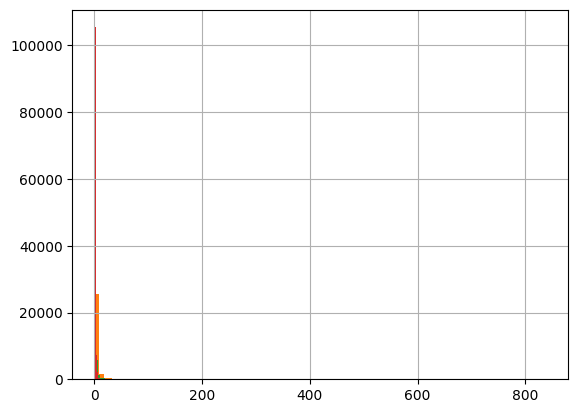

In [27]:
def process_clustering(name):
    clustering = pd.read_csv('clustering/{}_cluster.tsv'.format(name), delimiter='\t', header=None)
    #rename heading as cluster reference and id
    clustering.columns = [name, 'Entry']
    clustering.drop_duplicates(subset='Entry', keep='first', inplace=True)
    print(clustering[name].nunique())
    clustering[name].value_counts().hist(bins=100)
    return clustering

swissprot = swissprot[['Entry', 'Entry Name', 'Sequence', 'EC number', 'Length', 'EC All']]

cluster30 = process_clustering('clusterRes30')
cluster50 = process_clustering('clusterRes50')
cluster70 = process_clustering('clusterRes70')
cluster90 = process_clustering('clusterRes90')

swissprot = pd.merge(swissprot, cluster30, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster50, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster70, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster90, on='Entry', how='left')

# 25739
# 9012
# 61736
# 106727
swissprot

In [28]:
swissprot['EC3'] = swissprot['EC number'].str.split('.').str[:3].str.join('.')
swissprot['EC2'] = swissprot['EC number'].str.split('.').str[:2].str.join('.')
swissprot['EC1'] = swissprot['EC number'].str.split('.').str[:1].str.join('.')
swissprot.to_csv('../processed_data/protein2EC.csv', index=False)

# Finally process textual description of EC numbers
This is optionally used in CREEP

`raw_data/ECtoGO_raw.txt` was downloaded from http://current.geneontology.org/ontology/external2go/ec2go

In [30]:
#read ECtoGO.txt line by line
ECtoGO = open("raw_data/ECtoGO_raw.txt", "r")
ECtoGO_lines = ECtoGO.readlines()
ECtoGO.close()

#skip the first two lines
ECtoGO_lines = ECtoGO_lines[2:]
EC2desc = {}
for line in ECtoGO_lines:
    line = line.strip().split(">")
    EC = line[0][3:-1]
    desc = line[1].split(";")[0][4:-1]
    EC2desc[EC] = desc

def get_EC_desc(EC):
    num_dashes = EC.count('-')

    description_missing = False
    EC1 = '.'.join(EC.split('.')[:1])
    if EC1 + '.-.-.-' in EC2desc and num_dashes < 3:
        desc1 = EC2desc[EC1 + '.-.-.-']
    else:
         desc1 = ''
    EC2 = '.'.join(EC.split('.')[:2]) 
    if EC2 + '.-.-' in EC2desc and num_dashes < 2:
        desc2 = EC2desc[EC2 + '.-.-']
    else:
        desc2 = ''
    EC3 = '.'.join(EC.split('.')[:3])
    if EC3 + '.-' in EC2desc and num_dashes < 1:
        desc3 = EC2desc[EC3 + '.-']
    else:
        desc3 = ''
        
    if EC in EC2desc:
        desc4 = EC2desc[EC]
    else:
        description_missing = True
        desc4 = ''

  
    description = desc1 + '; ' + desc2 + '; ' + desc3 + '; ' + desc4
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' activity', '')
    #if string starts with ;, replace with space
    if description[0] == ';':
        description = description[2:]
    if description[-2:] == '; ':
        description = description[:-2]
    return description

#subset to the EC numbers in swissprot
EC2desc_df = pd.DataFrame(swissprot['EC number'].unique(), columns=['EC number'])
EC2desc_df['Text'] = EC2desc_df['EC number'].apply(get_EC_desc)
EC2desc_df['Text Incomplete'] = ~EC2desc_df['EC number'].isin(EC2desc.keys())
EC2desc_df = EC2desc_df.sort_values(by='EC number')
EC2desc_df = EC2desc_df[EC2desc_df['EC number'].isin(swissprot['EC number'].unique())]
EC2desc_df

,EC number,Text,Text Incomplete
327,1.1.1.1,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2573,1.1.1.10,"oxidoreductase; oxidoreductase, acting on CH-O...",False
1658,1.1.1.100,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2147,1.1.1.101,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2119,1.1.1.102,"oxidoreductase; oxidoreductase, acting on CH-O...",False
...,...,...,...
83,7.6.2.5,primary active transmembrane transporter; ABC-...,False
1727,7.6.2.6,primary active transmembrane transporter; ABC-...,False
4695,7.6.2.7,primary active transmembrane transporter; ABC-...,False
934,7.6.2.8,primary active transmembrane transporter; ABC-...,False


In [31]:
EC2desc_df.to_csv('../processed_data/text2EC.csv', index=False)

In [32]:
#save ECs to a txt as the order of the cluster centers for downstream tasks
with open('../processed_data/EC_list.txt', 'w') as f:
    for ec in EC2desc_df['EC number']:
        f.write(ec + '\n')

raw_data/price.tsv was downloaded from the CLEAN repo.